# Prep the data

The raw dataset is large and memory-intensive to preprocess, so we focus on a smaller subset of the region.
, clean and standardize the data for the UNet model.

Steps are:
* Load the raw data which has lat, lon, variable with gaps (in our case CHL) with gaps indicated with NaN, a land mask and any predictor variables.
* Subset to our smaller region.
* Add season variables (sin/cos)
* Add prior and next day CHL as extra predictors (in addition to the current day CHL)
* Create a fake clouds that will mask observed CHL
* Add masks for fake clouds (has an observed CHL), real clouds (does not have observed CHL), and valid CHL (observed CHL minus CHL covered with fake cloud).

Scroll to bottom for the code to prep all in one code block.



## Load mindthegap code
It is in the `mindthegap` folder in the root level of the repo.

In [1]:
import sys, os
# Specify the pathway
# Get project root 
project_root = os.path.dirname(os.getcwd())

# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print("Python path:", sys.path)

import mindthegap as mtg

## Crop a smaller region for demo

### Load the dataset
We start by loading the dataset of IO.zarr and slicing the region to the desired dimension.

In [2]:
import xarray as xr
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)

In [3]:
lat_min_full = zarr_ds['lat'].min().item()
lat_max_full = zarr_ds['lat'].max().item()
lon_min_full = zarr_ds['lon'].min().item()
lon_max_full = zarr_ds['lon'].max().item()

In [4]:
# Define bounding box
lat_min, lat_max = 5, 31
lon_min, lon_max = 42, 80

### Show the region

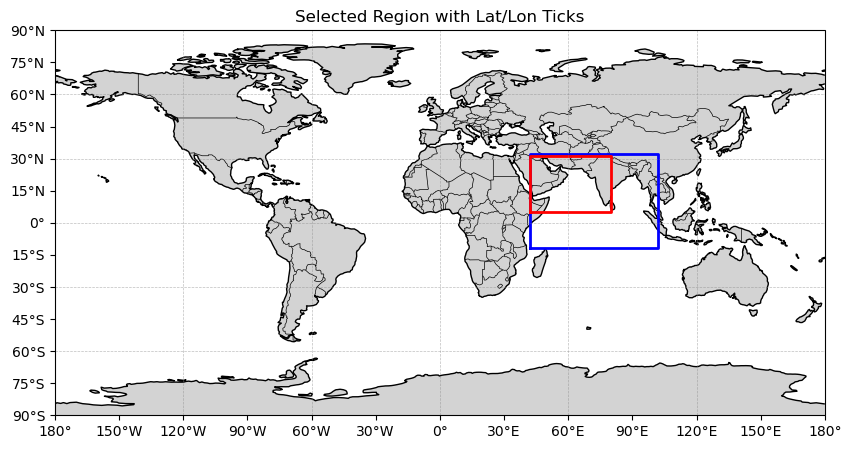

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

# Create a global map
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# Set extent to global instead of set_global()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add map features
# ax.coastlines()
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")

# Plot bounding box for orginal range
ax.plot(
    [lon_min_full, lon_max_full, lon_max_full, lon_min_full, lon_min_full],
    [lat_min_full, lat_min_full, lat_max_full, lat_max_full, lat_min_full],
    transform=ccrs.PlateCarree(),
    color="blue", linewidth=2
)

# Plot bounding box for smaller, desired area
ax.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    transform=ccrs.PlateCarree(),
    color="red", linewidth=2
)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False   # no labels at top
gl.right_labels = False # no labels at right

# Control tick locations
ax.set_xticks(range(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 15), crs=ccrs.PlateCarree())

# Format tick labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

plt.title("Selected Region with Lat/Lon Ticks")
plt.show()


### Slice and subset

In [6]:
import numpy as np
zarr_ds = zarr_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max))  # choose long and lat as we defined

In [7]:
zarr_ds

<xarray.Dataset> Size: 25GB
Dimensions:                       (time: 16071, lat: 105, lon: 153)
Coordinates:
  * lat                           (lat) float32 420B 31.0 30.75 ... 5.25 5.0
  * lon                           (lon) float32 612B 42.0 42.25 ... 79.75 80.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 1GB ...
    CHL_cmes-cloud                (time, lat, lon) uint8 258MB ...
    CHL_cmes-gapfree              (time, lat, lon) float32 1GB ...
    CHL_cmes-land                 (lat, lon) uint8 16kB ...
    CHL_cmes-level3               (time, lat, lon) float32 1GB ...
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 1GB ...
    ...                            ...
    ug_curr                       (time, lat, lon) float32 1GB ...
    v_curr                        (time, lat, lon) float32 1GB ...
    v_wind                        (time, lat, lon) float32 1GB ...
    vg_curr                       (time, lat, lon) float32 1GB ...
    wind_dir                      (time, lat, lon) float32 1GB ...
    wind_speed                    (time, lat, lon) float32 1GB ...
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Process data
Any variables in the `zarr_ds` can be pluged in and used as `features` to train the model. For simplicity here, we used `sst`.

#### Function: `data_preprocessing`
This function selects and standardizes feature variables, and store them to a zarr file for easy access in future training and evaluation.

##### Parameters:
- `zarr_ds`: original zarr dataset after region slicing and NaN CHL filtering
- `features`: a list of features available directly from _zarr_ds_
- `train_year`: the first year of train data
- `train_range`: length of train data in year


##### Other Features (X):
- `sin_time`:
$
\sin({\text{day in the year} \over 366} \cdot 2 \pi)
$
for seasonal information
- `cos_time`:
$
\cos({\text{day in the year} \over 366} \cdot 2 \pi)
$
for seasonal information as well
- `masked_CHL` (logged): artifically masked CHL to simulate cloud coverage. Artificial clouds are the overlapping pixels of _current day observed CHL location_ and _10 day after cloud location_
- `prev_day_CHL`: CHL data from the previous day
- `next_day_CHL`: CHL data from the next day
- `land_flag`: flag for land, with 1 = land and 0 = not land
- `real_cloud_flag`: flag for real cloud, with 1 = real cloud and 0 = not real cloud
- `valid_CHL_flag`: flag for observed CHL after applying artifical masks, with 1 = CHL observed and 0 = CHL not observed
- `fake_cloud_flag`: flag for fake cloud, with 1 = fake cloud and 0 = not fake cloud

##### label (y):
- `CHL` (logged): observed CHL

##### Standardization:
First standardize based on train dataset, and then apply the calculated mean and standard deviation to all data. Only numerical features and the label are standardized. Mean and standard deviation of _CHL_ and _masked_CHL_ are stored in a `.npy` file for evaluation. 

__Note__: If you run the code for the first time (the `data_preprocessing` function creates the zarr file), it is recommended to restart the kernel and release the memory. Otherwise you might run out of memory during the trainning phase. Also, create a folder named `data` inside your main directory.

In [ ]:
# create the zarr file
features = ['sst']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1

# "main directory" is the parent of the current working directory
main_dir = os.path.dirname(os.getcwd())

# path to main directory/data
data_dir = os.path.join(main_dir, "data")

# mtg.process.data_preprocessing
zarr_label = mtg.data_preprocessing(zarr_ds, features, train_year, train_range, 
                                    zarr_tag="ArabSea", datadir=data_dir)
zarr_label

label created


## All the code in one block
Run this to create the smaller dataset for the model.

In [1]:
import xarray as xr
import numpy as np
import mindthegap as mtg

# Get the full data set
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)
# Specify the smaller region and subset
lat_min, lat_max = 5, 31
lon_min, lon_max = 42, 80

zarr_ds = zarr_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max))  # choose long and lat

# create the zarr. Spec the years to use and features
features = ['sst']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1
datadir = "/home/jovyan/shared-public/mindthegap/data"

# functions are in mindthegap
zarr_label = mtg.data_preprocessing(zarr_ds, features, train_year, train_range, zarr_tag="ArabSea", datadir=datadir)
zarr_label

label created
raw data features added
CHL logged
sin and cos time calculated
sin time added
cos time added
masked CHL added
prev day CHL added
next day CHL added
land flag added
real cloud flag added
valid CHL flag added
fake cloud flag added
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
calculating mean and stdev...
standardizing...
standardizing...
standardizing...
standardizing...
standardizing...
standardizing...
all standardized
creating zarr


'2015_3_ArabSea'